In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

from model.inference import *
from model.hapke_model import get_USGS_r_mixed_hapke_estimate
from utils.access_data import *
from utils.constants import *

np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)

In [2]:
IMG_DIR = DATA_DIR + 'GALE_CRATER/cartOrder/cartorder/'
image_file = IMG_DIR + 'layered_img_sec_100_150.pickle'
wavelengths_file = IMG_DIR + 'layered_wavelengths.pickle'

# Normalize spectra across RELAB, USGS, and CRISM per each CRISM image
# (since different CRISM images have different wavelengths)
record_reduced_spectra(wavelengths_file)

image = get_CRISM_data(image_file, wavelengths_file, CRISM_match=True)
print("CRISM image size " + str(image.shape))

RELAB min:0.28 max: 2.6 count: 465
USGS min:0.2051 max: 2.976 count: 480
CRISM min:0.36462 max: 4.0 count: 545
not adding 2.624
CRISM_reduced min:0.36462 max: 2.58891 count: 277

All reduced spectra should have same length 
CRISM : 277
USGS 277
BASALT 277
CRISM image size (50, 50, 277)


## Testing
plot spectra of random pixels from image. frt0002037a_07_if165l_trr3_CAT

438
(450, 640, 438)


/Users/marina/Documents/PhD/research/mars_research/code/spectral_analysis/specenv/lib/python3.8/site-packages/spectral/graphics/spypylab.py:58: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  mpl.rcParams['keymap.all_axes'] = ''


ImageView object:
  Display bands       :  (300, 200, 50)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 0.05258666351437569]
    G: [0.0, 0.21590901911258698]
    B: [0.0, 0.20200224220752716]

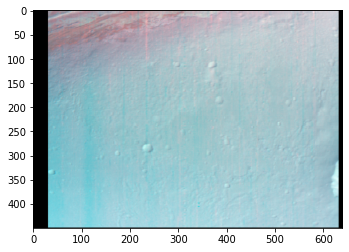

In [3]:
# load "l" image, reset all NULLs to 0 
CRISM_DATA_PATH = DATA_DIR + 'GALE_CRATER_TEST_2/'
CRISM_IMG = CRISM_DATA_PATH + 'frt0000c0ef_07_if165l_trr3_CAT.img'
spy_image = envi.open(file=CRISM_IMG + '.hdr')


image_arr = spy_image[:,:,:]
img= np.where(image_arr[:,:,:] == 65535, 0, image_arr) 
# S_IMG_WAVELENGTHS = CRISM_DATA_PATH + 'l_pixel_x_201_y_200.csv'
wavelengths = get_CRISM_wavelengths(CRISM_DATA_PATH + 'pixel_x_262_y_136.csv')



print(len(wavelengths))
print(img.shape)

bands = (300, 200, 50)
from spectral import imshow
imshow(data=img, bands=bands)

In [ ]:
#  height = 450
#  width = 640

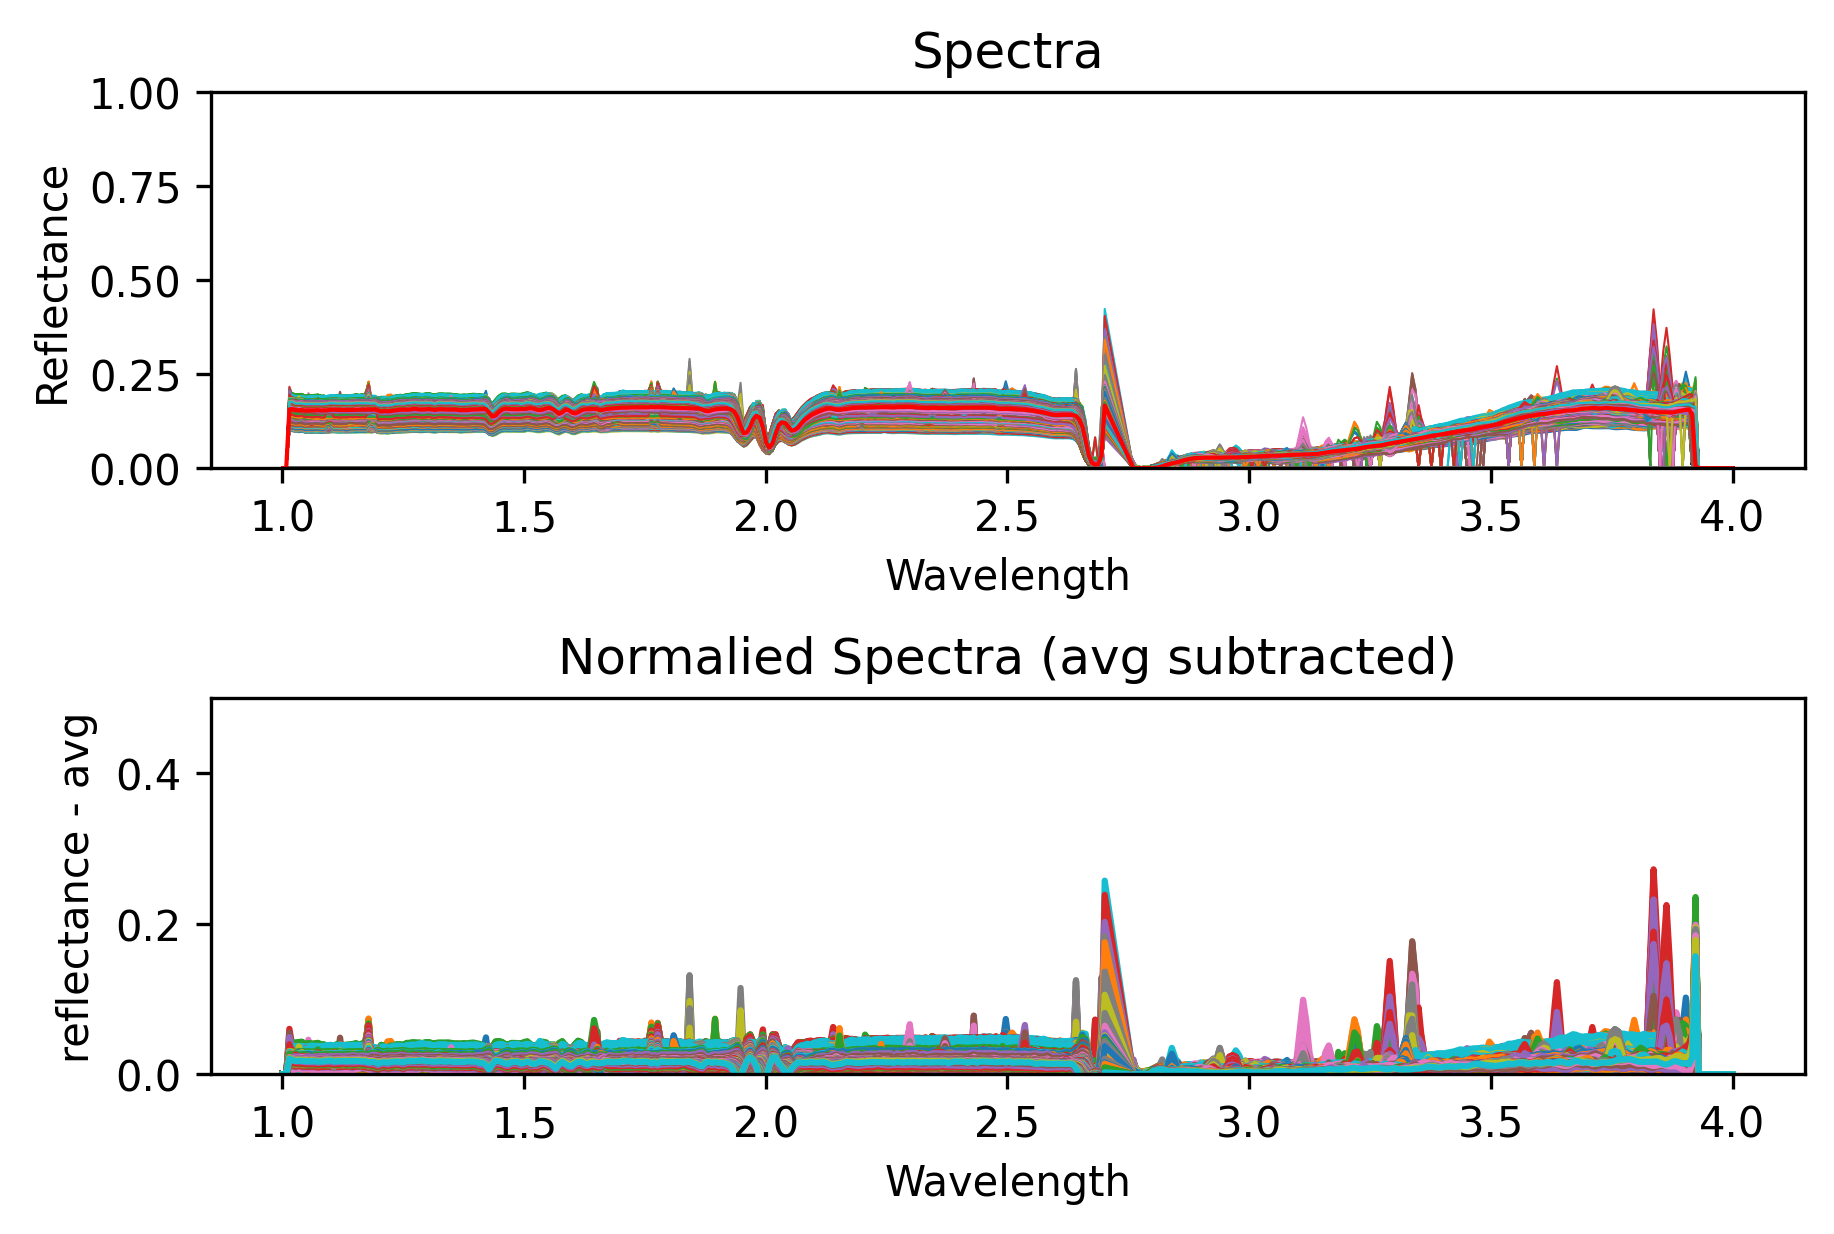

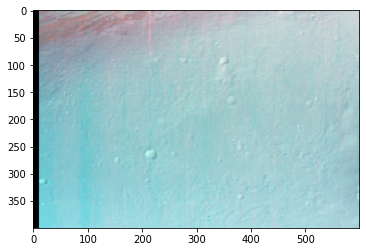

In [11]:
from spectral import imshow

def plot_cutout_spectra(img, wavelengths, sec_width, sec_height, xstart, ystart, bands):
    """
    Visualize subsection of image and corresponding spectra to see variance
    :param sec_width: number of columns to include
    :param sec_height: number of rows to include
    :param xstart: column to start at (where 0 is left most column)
    :param ystart: row to start at (where 0 is top row)
    """
    fig, ax = plt.subplots(2, 1, constrained_layout=True,  dpi=300 ) # figsize=(4, 2), dpi=DPI
    
    height, width, num_wavelengths = img.shape
    
    avg_spectra = np.zeros(num_wavelengths)
    num_pixels = sec_width*sec_height
     
    for i in range(sec_height):
        for j in range(sec_width): 
                            # img [ height, width ]
            pixel_spectra = img[i+ystart,j+xstart]
            ax[0].plot(wavelengths, pixel_spectra, linewidth=0.5)
            avg_spectra += pixel_spectra 
            
             
    avg_spectra = avg_spectra/num_pixels
    ax[0].plot(wavelengths, avg_spectra, linewidth=1.0, color='red')
    
    ax[0].set_xlabel("Wavelength")
    ax[0].set_ylabel("Reflectance")
    ax[0].set_title("Spectra")
    ax[0].set_ylim((0, 1))

    for i in range(sec_height):
        for j in range(sec_width): 
            pixel_spectra = img[i+ystart,j+xstart] 
            ax[1].plot(wavelengths, pixel_spectra-avg_spectra)
    ax[1].set_title("Normalied Spectra (avg subtracted)")
    ax[1].set_xlabel("Wavelength")
    ax[1].set_ylabel("reflectance - avg")
    ax[1].set_ylim((0,.5))
    
    plt.show()
    
    
     
    view = imshow(data=img[xstart:(xstart+sec_height),ystart:(ystart+sec_width),:], bands=bands)
    return avg_spectra/num_pixels

    

bands = (300, 200, 50)
avg_spectra=plot_cutout_spectra(img=img,
                    wavelengths=wavelengths,
                    sec_width = 600,
                    sec_height = 400,
                    xstart = 20,
                    ystart = 20,
                    bands=bands)


## PT sampler testing

In [ ]:
from emcee import PTSampler

# mu1 = [1, 1], mu2 = [-1, -1]
mu1 = np.ones(2)
mu2 = -np.ones(2)

# Width of 0.1 in each dimension
sigma1inv = np.diag([100.0, 100.0])
sigma2inv = np.diag([100.0, 100.0])

def logl(x):
    dx1 = x - mu1
    dx2 = x - mu2

    return np.logaddexp(-np.dot(dx1, np.dot(sigma1inv, dx1))/2.0,
                        -np.dot(dx2, np.dot(sigma2inv, dx2))/2.0)

# Use a flat prior
def logp(x):
    return 0.0

In [ ]:
ntemps = 4
nwalkers = 10
ndim = 2

num_burnin_iterations = 100

sampler=PTSampler(ntemps, nwalkers, ndim, logl, logp)
p0 = np.random.uniform(low=-1.0, high=1.0, size=(ntemps, nwalkers, ndim))
for p, lnprob, lnlike in sampler.sample(p0, iterations=num_burnin_iterations):
    pass
sampler.reset()

In [ ]:
# At each iteration, this generator for PTSampler yields

# p, the current position of the walkers.
# lnprob the current posterior values for the walkers.
# lnlike the current likelihood values for the walkers.

In [ ]:
num_iterations = 100

for p, lnprob, lnlike in sampler.sample(p0=p, lnprob0=lnprob,
                                           lnlike0=lnlike,
                                           iterations=num_iterations, 
                                        thin=10):
    pass

In [ ]:
assert sampler.chain.shape == (ntemps, nwalkers, 20, ndim)

In [ ]:
assert sampler.chain.shape == (ntemps, nwalkers, 1000, ndim)

# Chain has shape (ntemps, nwalkers, nsteps, ndim)
# Zero temperature mean:
mu0 = np.mean(np.mean(sampler.chain[0,...], axis=0), axis=0)

# Longest autocorrelation length (over any temperature)
max_acl = np.max(sampler.acor)

# etc

## Infer point

In [2]:

# ['olivine (Fo51)',
# 'olivine (Fo80)',
# 'augite',
# 'labradorite',
# 'pigeonite',
# 'magnetite',
# 'basaltic glass']
m_random = np.array([0, 0, 0, 0, 0, 0, 1])
D_random = np.array([30, 300, 60, 60, 60, 60, 60])
true_m = convert_arr_to_dict(m_random)
true_D = convert_arr_to_dict(D_random)
r_actual = get_USGS_r_mixed_hapke_estimate(m=true_m, D=true_D)


In [3]:
np.set_printoptions(precision=2)
est_m, est_D = infer_datapoint(iterations=2000,d=r_actual)

Finished datapoint.


Estimated m [0.   0.03 0.01 0.05 0.   0.53 0.38]
Real m    [0 0 0 0 0 0 1]

Estimated D [148. 135.  86.  43.  25. 141.  50.]
Real D    [ 30 300  60  60  60  60  60]

 Prob of estimate 3.4360698211752328e+165
 Prob of real 2.8319672872277624e+166


(0.0, 1.0)

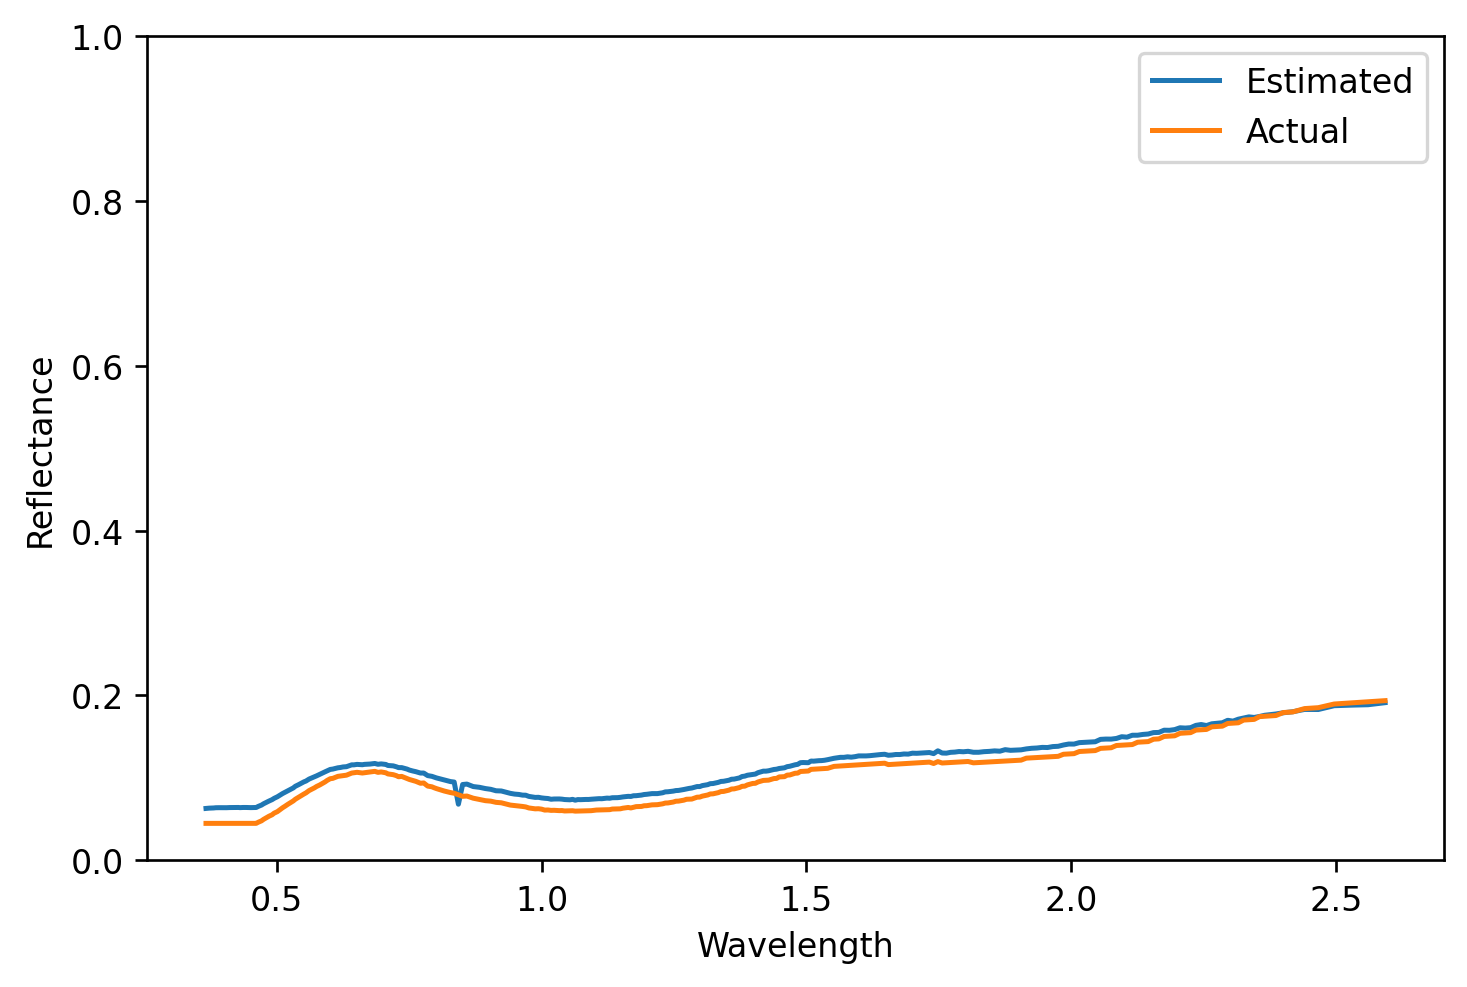

In [4]:
print("Estimated m " + str(est_m))
print("Real m    " + str(m_random))

print("\nEstimated D " + str(est_D))
print("Real D    " + str(D_random))

p = get_likelihood(r_actual, convert_arr_to_dict(est_m), convert_arr_to_dict(est_D))
print("\n Prob of estimate " + str(p))
p = get_likelihood(r_actual, true_m, true_D)
print(" Prob of real " + str(p))


wavelengths = get_USGS_wavelengths(True)
r_est = get_USGS_r_mixed_hapke_estimate(convert_arr_to_dict(est_m),
                                          convert_arr_to_dict(est_D))
fig, ax = plt.subplots(1, 1, constrained_layout=True,
                       figsize=(FIG_WIDTH, FIG_HEIGHT), dpi=DPI)
ax.plot(wavelengths, r_est, label = "Estimated")
ax.plot(wavelengths, r_actual, label = "Actual")

ax.set_xlabel("Wavelength")
ax.set_ylabel("Reflectance")
ax.legend()

plt.ylim((0, 1))

In [ ]:
p = get_posterior_estimate(r_actual, m_random, D_random)
print(" Prob of real " + str(p))

In [ ]:
mbetter= np.array([0.  , 0.11, 0.02 ,0.07 ,0.01 ,0. ,  0.79])
Dbetter=np.array([207., 127. ,182. ,176.  ,24. , 36. ,110.])

# [0.   0.11 0.02 0.07 0.01 0.   0.79]
# [207. 127. 182. 176.  24.  36. 110.]

pa = get_posterior_estimate(r_actual, mbetter, Dbetter)
print(" Prob of higher prob, worse pred " + str(pa))

In [ ]:
p>=6.178837717587845e+166

In [ ]:



# Old m is better than new m so we should NOT accept the new. 
# old_m = np.array([0.18, 0.07, 0, 0, 0, 0, 0.74 ])
# new_m = np.array([0.33, 0.04, 0, 0, 0.05, 0, 0.58])


# old_D = np.array([60, 60, 60, 60, 60, 60, 60])
# new_D = np.array([60, 60, 60, 60, 60, 60, 60])


new_m = np.array([0, 0, 0, 0, 0, 0.1, 0.9 ])
new_D =  np.array([60, 60, 60, 60, 60, 60, 60])

old_m = [0.38, 0.01, 0.003, 0, 0.02, 0, 0.57]
old_D = [300, 300, 300, 100, 100, 200, 200]


old_m_dict = convert_arr_to_dict(old_m)
new_m_dict = convert_arr_to_dict(new_m)
old_D_dict = convert_arr_to_dict(old_D)
new_D_dict = convert_arr_to_dict(new_D)

ll_old = get_likelihood(r_actual, old_m_dict, old_D_dict)
ll_new = get_likelihood(r_actual, new_m_dict, new_D_dict)

ratio = ll_new / ll_old
print(ratio)

In [ ]:
wavelengths = get_USGS_wavelengths(True)
old_r_e = get_USGS_r_mixed_hapke_estimate(old_m_dict, old_D_dict)
new_r_e = get_USGS_r_mixed_hapke_estimate(new_m_dict, new_D_dict)
true_r = get_USGS_r_mixed_hapke_estimate(true_m, true_D)


fig, ax = plt.subplots(1, 1, constrained_layout=True,
                       figsize=(FIG_WIDTH, FIG_HEIGHT), dpi=DPI)
ax.plot(wavelengths, old_r_e, label = "Current")
ax.plot(wavelengths, new_r_e, label = "New")
ax.plot(wavelengths, true_r, label = "Actual")

ax.set_xlabel("Wavelength")
ax.set_ylabel("Reflectance")
ax.legend()

plt.ylim((0, 1))